# Counterfactual analysis in a medical case

In this example we examine a case where we want to ask counterfactual questions, for events that have already taken place. We focus on a tele-medicine example related to eye-sight problems, where we know the causal structure of three observed variables and we want to ask counterfactual questions based of the type "What would have happened had I followed a different approach of what the tele-medicine app had proposed?".

More specifically, we consider the following case.
Alice who experiences intense eye-dryness decides to use a tele-medicine online platform, as she is not able to visit an eye doctor where she lives. She goes through the steps of reporting her medical history that reveals whether Alice has a rare allergy or not and the platform in the end recommends her two possible eye drops, with slightly different ingredients ('option 1' and 'option 2'). Alice does a quick search online, and she finds that there are many positive reviews for option 1. Nevertheless, she decides to use option 2 as her mother has also used it in the past, and it had positive results. After a couple of days Alice's vision becomes much better and her symptoms start to disappear. However, she is very curious what would have happened if she had used the very popular option 1 instead, or even did nothing.

The platform provides the possibility for the user to ask counterfactual questions as long as they report the outcome of the option they followed. 

## The data

We are having a database consisting of three observed variables: A continuous variable from 0 to 1 that indicates the quality of eyesight ('Vision'), a binary variable that indicates whether a patient has a rare condition (i.e. allergy) or not ('Condition'), and a categorical variable ('Treatment') that can take three values (0: 'Do nothing', 1: 'option 1' or 2: 'option 2').
The data looks like this:

In [1]:
import pandas as pd

medical_data = pd.read_csv('patients_database.csv')
medical_data.head()

,Condition,Treatment,Vision
0,0,2,0.111728
1,0,0,0.191516
2,0,2,0.163924
3,0,1,0.886563
4,0,1,0.761090


<AxesSubplot:>

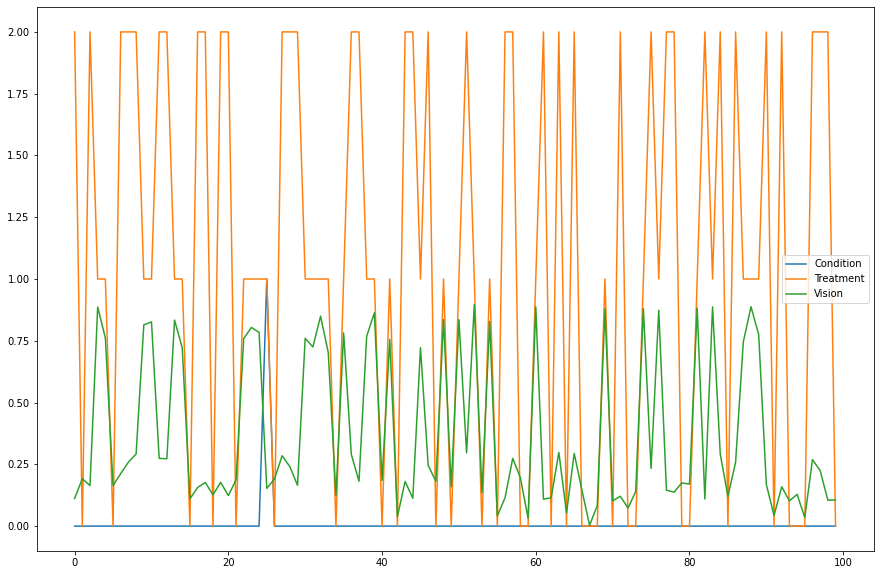

In [2]:
medical_data.iloc[0:100].plot(figsize=(15, 10))

The dataset reflects the Vision of patients after they have taken one of the three Treatment options based on whether they have the rare Condition or not. Notice that the dataset has no information about the original vision of the patients (i.e. the noise of the Vision variable) before the treatment. As we will see below, this noise part of the vision is being recovered by the counterfactual algorithm as long as we have a post-nonlinear model (e.g. an ANM). The structural causal model used for the generation of the data is explained in detail in the Appendix. Each of these three observed nodes has an intrinsic noise, which is not observed.

## Modeling of the graph

We know that the Treatment node and the Condition node are causing the Vision, but we don't know the structural causal model. However, we can learn it from the observed data and, in particular, as long as post non-linear model assumption is not violated, we are able to reconstruct the noise for a particular observation. We assume that this graph is correctly representing the causal relationships, and we assume that there are no hidden confounders (causal sufficiency). Based on the given graph and data, we can then fit the causal model and start answering counterfactual questions.

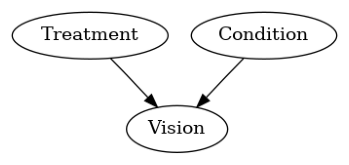

Fitting causal models:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node Treatment:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node Vision:   0%|          | 0/3 [00:00<?, ?it/s]   

Fitting causal mechanism of node Vision:  67%|██████▋   | 2/3 [00:00<00:00, 11.48it/s]

Fitting causal mechanism of node Condition:  67%|██████▋   | 2/3 [00:00<00:00, 11.48it/s]

Fitting causal mechanism of node Condition: 100%|██████████| 3/3 [00:00<00:00, 16.93it/s]

In [3]:
import networkx as nx
import dowhy.gcm as gcm

causal_model = gcm.InvertibleStructuralCausalModel(nx.DiGraph([('Treatment', 'Vision'), ('Condition', 'Vision')]))
gcm.auto.assign_causal_mechanisms(causal_model, medical_data)

gcm.util.plot(causal_model.graph)

gcm.fit(causal_model, medical_data)

Now returning to our original problem, let's load Alice's data, who happens to have a rare allergy (Condition = 1).

In [4]:
specific_patient_data = pd.read_csv('newly_come_patients.csv')
specific_patient_data.head()

,Condition,Treatment,Vision
0,1,2,0.883874


## Answering Alice's counterfactual queries


In cases where we want to examine a hypothetical outcome if an event had not happened or if it had happened
differently, we employ the so-called Counterfactual logic based on structural causal models. Given:
- We know Alice's treatment was option 2.
- Alice has the rare allergy (Condition=1).
- Alice vision is 0.78 (Vision=0.78) after treatment option 2.
- We are able to recover the noise based on the learned structural causal model.

We can now examine the counterfactual outcome for her Vision if the Treatment node had been different. In the following,
we look at the counterfactual value for Vision of Alice if she had taken no treatment (Treatment=0) and if she had taken the other eye drops (Treatment=1).

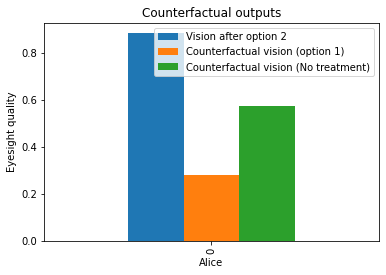

In [5]:
counterfactual_data1 = gcm.counterfactual_samples(causal_model,
                                                  {'Treatment': lambda x: 1},
                                                  observed_data = specific_patient_data)
                                                   
counterfactual_data2 = gcm.counterfactual_samples(causal_model,
                                                  {'Treatment': lambda x: 0},
                                                  observed_data = specific_patient_data)
    

import matplotlib.pyplot as plt

df_plot2 = pd.DataFrame()
df_plot2['Vision after option 2'] = specific_patient_data['Vision']
df_plot2['Counterfactual vision (option 1)'] = counterfactual_data1['Vision']
df_plot2['Counterfactual vision (No treatment)'] = counterfactual_data2['Vision']

df_plot2.plot.bar(title="Counterfactual outputs")
plt.xlabel('Alice')
plt.ylabel('Eyesight quality')
plt.legend()    

What we see here is that if Alice had taken option 1 instead, her Vision would have become worse compared to option 2. Therefore, she realised that the rare condition (Condition=1) that she had reported in her medical history could be the one that would have caused an allergic reaction to the popular option 1. Alice was also able to see that if she had not taken any of the recommended options, she would have resulted with worse eyesight (the variable Vision resulted in a smaller relative value) than with option 2 that she took.

## Appendix: What the tele-app uses internally. Data generation of the patients' log

Here we describe the SCM $f_{p1, p2}$ for the additive noise model:  $Vision = N_V + f_{p1, p2}(Treatment, Condition)$.
We sample the intrinsic additive noise for the three observed variables $N_T, N_C$ and $N_V$. The target variable Vision is then the additive noise $N_V$ plus the function of its inputs nodes as described below.

 $Treatment = N_T$ ~ 0 , 1 or 2 with probabilities 33% respectively : 33% of the users do nothing, 33% take option 1 and 33% take option 2. This is independent of whether the
 patient has the rare condition.

 $Condition =  N_C$ ~ Bernoulli(0.01) : whether the patient has the rare condition

 $Vision = N_V + f_{p1, p2}(Treatment, Condition) = N_V - P_1(1 - Condition)(1-Treatment)(2-Treatment) + 2P_2(1-Condition)Treatment(2-Treatment) + P_2(1-Condition)(3-Treatment)(1-Treatment)Treatment - 2P_2 Condition Treatment(2-Treatment) - P_2 Condition(3-Treatment)(1-Treatment)Treatment   $ patient's vision,
 where:

 $P_1$ is a constant by which the original vision will be decreased in case the patient does not have the rare condition and he is not administrated any medicine.

 $P_2$ is a constant by which the original vision will be increased or decreased accordingly depending on whether the patient has the condition and the type of drops they will be administrated. 
 More specifically: 
 
 If Condition = 0 and Treatment = 1 then Vision =  N_V + P_2 
 
 elIf Condition = 0 and Treatment = 2 then Vision =  N_V - P_2 
 
 elIf Condition = 1 and Treatment = 1 then Vision =  N_V - P_2
 
 elIf Condition = 1 and Treatment = 2 then Vision =  N_V + P_2 
 
 elIf Condition = 0 and Treatment = 0 then Vision =  N_V - P_1
 
 elif Condition = 1 and Treatment = 0 then Vision = N_V - P3
 


---
**NOTE**
It is important that the assigned functional causal models are invertible with respect to the noise (e.g. an additive noise model) for counterfactual statements. Alternatively, the user could also specify the ground truth models and ground truth noise.
---

For such rare events like having the condition (Condition=1, which has a low probability of 1%) it is necessary to have a lot of samples to train the model in order to accurately reflect these rare events. This is why here we used 10000 samples to generate the patients' database.

In [6]:
from scipy.stats import bernoulli, norm, uniform 
import numpy as np
from random import randint

n_unobserved = 10000
unobserved_data = {
   'N_T': np.array([randint(0, 2) for p in range(n_unobserved)]),
   'N_vision': np.random.uniform(0.4, 0.6, size=(n_unobserved,)),
   'N_C': bernoulli.rvs(0.01, size=n_unobserved)
}
P_1 = 0.2
P_2 = 0.15

def create_observed_medical_data(unobserved_data):
    observed_medical_data = {}
    observed_medical_data['Condition'] = unobserved_data['N_C']
    observed_medical_data['Treatment'] = unobserved_data['N_T']
    observed_medical_data['Vision'] = unobserved_data['N_vision'] + (-P_1)*(1 - observed_medical_data['Condition'])*(1 - observed_medical_data['Treatment'])*(2 - observed_medical_data['Treatment']) + (2*P_2)*(1 - observed_medical_data['Condition'])*(observed_medical_data['Treatment'])*(2 - observed_medical_data['Treatment']) + (P_2)*(1 - observed_medical_data['Condition'])*(observed_medical_data['Treatment'])*(1 - observed_medical_data['Treatment'])*(3 - observed_medical_data['Treatment']) + 0*(observed_medical_data['Condition'])*(1 - observed_medical_data['Treatment'])*(2 - observed_medical_data['Treatment']) + (-2*P_2)*(unobserved_data['N_C'])*(observed_medical_data['Treatment'])*(2 - observed_medical_data['Treatment']) + (-P_2)*(observed_medical_data['Condition'])*(observed_medical_data['Treatment'])*(1 - observed_medical_data['Treatment'])*(3 - observed_medical_data['Treatment'])     
    return pd.DataFrame(observed_medical_data)

medical_data = create_observed_medical_data(unobserved_data)

Generate Alice's data: A random noise for her initial vision, Condition=1 (as she has the rare allergy) and her initial decision to take Treatment=2 (eye drops option 2).

In [7]:

num_samples = 1
original_vision = np.random.uniform(0.4, 0.6, size=num_samples)
def generate_specific_patient_data(num_samples):
    return create_observed_medical_data({
    'N_T': np.full((num_samples,), 2),
    'N_C': bernoulli.rvs(1, size=num_samples),
    'N_vision': original_vision,
})

specific_patient_data = generate_specific_patient_data(num_samples)